# Method 3 - Rest Ideas After 10

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Intra-Portfolio Cap Weight

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Calculate Intra-Portfolio Cap Weight Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 10].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

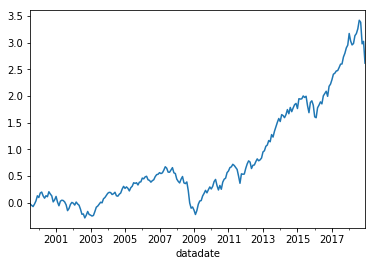

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.128874
2000-12-31   -0.067527
2001-12-31   -0.045556
2002-12-31   -0.223978
2003-12-31    0.455788
2004-12-31    0.151037
2005-12-31    0.063589
2006-12-31    0.103401
2007-12-31    0.008782
2008-12-31   -0.405612
2009-12-31    0.408957
2010-12-31    0.206681
2011-12-31   -0.016668
2012-12-31    0.195669
2013-12-31    0.402888
2014-12-31    0.109630
2015-12-31   -0.011579
2016-12-31    0.139632
2017-12-31    0.226888
2018-12-31   -0.085441
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     3369.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.87e-202
Time:                        12:53:46   Log-Likelihood:                 854.13
No. Observations:                 234   AIC:                            -1698.
Df Residuals:                     229   BIC:                            -1681.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.000      4.745      0.000       0.001       0.003
mktrf          1.0174      0.012     85.816      0.000       0.994       1.041
me             0.2112      0.014     15.312      0.000       0.184       0.238
ia             0.0291      0.021      1.387      0.167      -0.012       0.070
roe           -0.0820      0.018     -4.568      0.000      -0.117      -0.047
==============================================================================
Omnibus:                       23.407   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.052
Skew:                          -0.180   Prob(JB):                     6.22e-21
Kurtosis:                       6.068   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     1660.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.54e-168
Time:                        12:53:46   Log-Likelihood:                 854.13
No. Observations:                 234   AIC:                            -1698.
Df Residuals:                     229   BIC:                            -1681.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.000      4.231      0.000       0.001       0.003
mktrf          1.0174      0.014     72.587      0.000       0.990       1.045
me             0.2112      0.019     11.063      0.000       0.174       0.249
ia             0.0291      0.038      0.773      0.439      -0.045       0.103
roe           -0.0820      0.028     -2.907      0.004      -0.137      -0.027
==============================================================================
Omnibus:                       23.407   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.052
Skew:                          -0.180   Prob(JB):                     6.22e-21
Kurtosis:                       6.068   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     1698.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.66e-169
Time:                        12:53:46   Log-Likelihood:                 854.13
No. Observations:                 234   AIC:                            -1698.
Df Residuals:                     229   BIC:                            -1681.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.000      4.231      0.000       0.001       0.003
mktrf          1.0174      0.015     69.785      0.000       0.989       1.046
me             0.2112      0.018     11.701      0.000       0.176       0.247
ia             0.0291      0.038      0.758      0.448      -0.046       0.104
roe           -0.0820      0.032     -2.569      0.010      -0.144      -0.019
==============================================================================
Omnibus:                       23.407   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.052
Skew:                          -0.180   Prob(JB):                     6.22e-21
Kurtosis:                       6.068   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     2462.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.61e-196
Time:                        12:53:46   Log-Likelihood:                 844.26
No. Observations:                 234   AIC:                            -1677.
Df Residuals:                     228   BIC:                            -1656.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.000      3.911      0.000       0.001       0.003
mktrf          1.0340      0.012     83.267      0.000       1.010       1.058
smb            0.2298      0.016     14.023      0.000       0.197       0.262
hml            0.0178      0.019      0.924      0.357      -0.020       0.056
rmw           -0.0659      0.022     -3.018      0.003      -0.109      -0.023
cma            0.0306      0.028      1.102      0.271      -0.024       0.085
==============================================================================
Omnibus:                       27.236   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.298
Skew:                           0.013   Prob(JB):                     1.71e-32
Kurtosis:                       6.874   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     2320.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.82e-193
Time:                        12:53:46   Log-Likelihood:                 844.26
No. Observations:                 234   AIC:                            -1677.
Df Residuals:                     228   BIC:                            -1656.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.000      3.699      0.000       0.001       0.003
mktrf          1.0340      0.012     83.414      0.000       1.010       1.058
smb            0.2298      0.022     10.476      0.000       0.187       0.273
hml            0.0178      0.042      0.422      0.673      -0.065       0.101
rmw           -0.0659      0.030     -2.196      0.028      -0.125      -0.007
cma            0.0306      0.039      0.778      0.437      -0.046       0.108
==============================================================================
Omnibus:                       27.236   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.298
Skew:                           0.013   Prob(JB):                     1.71e-32
Kurtosis:                       6.874   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     2781.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.33e-202
Time:                        12:53:46   Log-Likelihood:                 844.26
No. Observations:                 234   AIC:                            -1677.
Df Residuals:                     228   BIC:                            -1656.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      3.509      0.000       0.001       0.003
mktrf          1.0340      0.012     85.930      0.000       1.010       1.058
smb            0.2298      0.019     11.799      0.000       0.192       0.268
hml            0.0178      0.043      0.410      0.682      -0.067       0.103
rmw           -0.0659      0.033     -1.977      0.048      -0.131      -0.001
cma            0.0306      0.038      0.800      0.424      -0.044       0.106
==============================================================================
Omnibus:                       27.236   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.298
Skew:                           0.013   Prob(JB):                     1.71e-32
Kurtosis:                       6.874   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     2946.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.38e-195
Time:                        12:53:46   Log-Likelihood:                 838.71
No. Observations:                 234   AIC:                            -1667.
Df Residuals:                     229   BIC:                            -1650.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.000      3.999      0.000       0.001       0.003
mktrf          1.0292      0.012     88.281      0.000       1.006       1.052
smb            0.2514      0.015     17.277      0.000       0.223       0.280
hml            0.0463      0.014      3.205      0.002       0.018       0.075
umd           -0.0400      0.009     -4.214      0.000      -0.059      -0.021
==============================================================================
Omnibus:                       22.258   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.977
Skew:                          -0.086   Prob(JB):                     1.76e-20
Kurtosis:                       6.050   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     2168.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.10e-180
Time:                        12:53:46   Log-Likelihood:                 838.71
No. Observations:                 234   AIC:                            -1667.
Df Residuals:                     229   BIC:                            -1650.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      3.303      0.001       0.001       0.003
mktrf          1.0292      0.015     68.008      0.000       1.000       1.059
smb            0.2514      0.017     14.510      0.000       0.217       0.285
hml            0.0463      0.039      1.183      0.237      -0.030       0.123
umd           -0.0400      0.016     -2.555      0.011      -0.071      -0.009
==============================================================================
Omnibus:                       22.258   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.977
Skew:                          -0.086   Prob(JB):                     1.76e-20
Kurtosis:                       6.050   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     2382.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.99e-185
Time:                        12:53:46   Log-Likelihood:                 838.71
No. Observations:                 234   AIC:                            -1667.
Df Residuals:                     229   BIC:                            -1650.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      3.143      0.002       0.001       0.003
mktrf          1.0292      0.014     72.541      0.000       1.001       1.057
smb            0.2514      0.017     14.446      0.000       0.217       0.286
hml            0.0463      0.044      1.064      0.287      -0.039       0.132
umd           -0.0400      0.014     -2.923      0.003      -0.067      -0.013
==============================================================================
Omnibus:                       22.258   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.977
Skew:                          -0.086   Prob(JB):                     1.76e-20
Kurtosis:                       6.050   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     1583.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.64e-99
Time:                        12:53:46   Log-Likelihood:                 421.10
No. Observations:                 120   AIC:                            -832.2
Df Residuals:                     115   BIC:                            -818.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.658      0.000       0.001       0.004
mktrf          1.0116      0.019     53.068      0.000       0.974       1.049
me             0.1954      0.019     10.379      0.000       0.158       0.233
ia             0.0721      0.029      2.444      0.016       0.014       0.130
roe           -0.1036      0.026     -3.971      0.000      -0.155      -0.052
==============================================================================
Omnibus:                        9.946   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               20.508
Skew:                          -0.220   Prob(JB):                     3.52e-05
Kurtosis:                       4.977   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     1045.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.27e-89
Time:                        12:53:46   Log-Likelihood:                 421.10
No. Observations:                 120   AIC:                            -832.2
Df Residuals:                     115   BIC:                            -818.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.224      0.001       0.001       0.004
mktrf          1.0116      0.023     43.957      0.000       0.966       1.057
me             0.1954      0.022      8.889      0.000       0.152       0.239
ia             0.0721      0.043      1.678      0.093      -0.012       0.156
roe           -0.1036      0.033     -3.103      0.002      -0.169      -0.038
==============================================================================
Omnibus:                        9.946   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               20.508
Skew:                          -0.220   Prob(JB):                     3.52e-05
Kurtosis:                       4.977   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     1456.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.79e-97
Time:                        12:53:46   Log-Likelihood:                 421.10
No. Observations:                 120   AIC:                            -832.2
Df Residuals:                     115   BIC:                            -818.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.100      0.002       0.001       0.004
mktrf          1.0116      0.022     46.367      0.000       0.969       1.054
me             0.1954      0.022      8.952      0.000       0.153       0.238
ia             0.0721      0.038      1.880      0.060      -0.003       0.147
roe           -0.1036      0.037     -2.794      0.005      -0.176      -0.031
==============================================================================
Omnibus:                        9.946   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               20.508
Skew:                          -0.220   Prob(JB):                     3.52e-05
Kurtosis:                       4.977   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1070.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.13e-94
Time:                        12:53:46   Log-Likelihood:                 411.72
No. Observations:                 120   AIC:                            -811.4
Df Residuals:                     114   BIC:                            -794.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      3.614      0.000       0.001       0.004
mktrf          1.0647      0.022     48.773      0.000       1.021       1.108
smb            0.2322      0.025      9.392      0.000       0.183       0.281
hml            0.0032      0.030      0.107      0.915      -0.057       0.063
rmw           -0.0444      0.036     -1.244      0.216      -0.115       0.026
cma            0.0901      0.039      2.303      0.023       0.013       0.168
==============================================================================
Omnibus:                       14.886   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               45.924
Skew:                          -0.254   Prob(JB):                     1.07e-10
Kurtosis:                       5.988   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1424.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.93e-101
Time:                        12:53:46   Log-Likelihood:                 411.72
No. Observations:                 120   AIC:                            -811.4
Df Residuals:                     114   BIC:                            -794.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      3.411      0.001       0.001       0.004
mktrf          1.0647      0.024     44.757      0.000       1.018       1.111
smb            0.2322      0.033      7.020      0.000       0.167       0.297
hml            0.0032      0.070      0.046      0.963      -0.135       0.141
rmw           -0.0444      0.053     -0.837      0.402      -0.148       0.060
cma            0.0901      0.046      1.965      0.049       0.000       0.180
==============================================================================
Omnibus:                       14.886   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               45.924
Skew:                          -0.254   Prob(JB):                     1.07e-10
Kurtosis:                       5.988   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     2403.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.66e-114
Time:                        12:53:46   Log-Likelihood:                 411.72
No. Observations:                 120   AIC:                            -811.4
Df Residuals:                     114   BIC:                            -794.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      3.282      0.001       0.001       0.005
mktrf          1.0647      0.021     49.917      0.000       1.023       1.107
smb            0.2322      0.031      7.575      0.000       0.172       0.292
hml            0.0032      0.074      0.044      0.965      -0.142       0.148
rmw           -0.0444      0.058     -0.770      0.441      -0.158       0.069
cma            0.0901      0.044      2.042      0.041       0.004       0.177
==============================================================================
Omnibus:                       14.886   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               45.924
Skew:                          -0.254   Prob(JB):                     1.07e-10
Kurtosis:                       5.988   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1267.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.59e-94
Time:                        12:53:46   Log-Likelihood:                 408.01
No. Observations:                 120   AIC:                            -806.0
Df Residuals:                     115   BIC:                            -792.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      3.871      0.000       0.001       0.005
mktrf          1.0378      0.019     55.407      0.000       1.001       1.075
smb            0.2568      0.021     12.042      0.000       0.215       0.299
hml            0.0667      0.021      3.122      0.002       0.024       0.109
umd           -0.0422      0.013     -3.203      0.002      -0.068      -0.016
==============================================================================
Omnibus:                       12.650   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               28.806
Skew:                          -0.318   Prob(JB):                     5.56e-07
Kurtosis:                       5.314   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1175.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.13e-92
Time:                        12:53:46   Log-Likelihood:                 408.01
No. Observations:                 120   AIC:                            -806.0
Df Residuals:                     115   BIC:                            -792.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      3.917      0.000       0.001       0.004
mktrf          1.0378      0.024     43.212      0.000       0.991       1.085
smb            0.2568      0.023     11.000      0.000       0.211       0.303
hml            0.0667      0.052      1.282      0.200      -0.035       0.169
umd           -0.0422      0.019     -2.227      0.026      -0.079      -0.005
==============================================================================
Omnibus:                       12.650   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               28.806
Skew:                          -0.318   Prob(JB):                     5.56e-07
Kurtosis:                       5.314   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1338.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.11e-95
Time:                        12:53:46   Log-Likelihood:                 408.01
No. Observations:                 120   AIC:                            -806.0
Df Residuals:                     115   BIC:                            -792.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      3.952      0.000       0.002       0.004
mktrf          1.0378      0.020     51.429      0.000       0.998       1.077
smb            0.2568      0.025     10.209      0.000       0.207       0.306
hml            0.0667      0.057      1.170      0.242      -0.045       0.178
umd           -0.0422      0.017     -2.547      0.011      -0.075      -0.010
==============================================================================
Omnibus:                       12.650   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               28.806
Skew:                          -0.318   Prob(JB):                     5.56e-07
Kurtosis:                       5.314   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2263.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.05e-104
Time:                        12:53:46   Log-Likelihood:                 453.92
No. Observations:                 114   AIC:                            -897.8
Df Residuals:                     109   BIC:                            -884.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.000      3.310      0.001       0.001       0.002
mktrf          1.0244      0.014     75.490      0.000       0.998       1.051
me             0.2418      0.021     11.540      0.000       0.200       0.283
ia            -0.0909      0.029     -3.127      0.002      -0.148      -0.033
roe           -0.0769      0.026     -3.009      0.003      -0.127      -0.026
==============================================================================
Omnibus:                        7.944   Durbin-Watson:                   2.255
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                7.573
Skew:                          -0.588   Prob(JB):                       0.0227
Kurtosis:                       3.460   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     3620.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.96e-115
Time:                        12:53:46   Log-Likelihood:                 453.92
No. Observations:                 114   AIC:                            -897.8
Df Residuals:                     109   BIC:                            -884.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.000      3.794      0.000       0.001       0.002
mktrf          1.0244      0.010     97.900      0.000       1.004       1.045
me             0.2418      0.017     14.308      0.000       0.209       0.275
ia            -0.0909      0.027     -3.411      0.001      -0.143      -0.039
roe           -0.0769      0.024     -3.144      0.002      -0.125      -0.029
==============================================================================
Omnibus:                        7.944   Durbin-Watson:                   2.255
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                7.573
Skew:                          -0.588   Prob(JB):                       0.0227
Kurtosis:                       3.460   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     5062.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.04e-123
Time:                        12:53:46   Log-Likelihood:                 453.92
No. Observations:                 114   AIC:                            -897.8
Df Residuals:                     109   BIC:                            -884.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.000      3.951      0.000       0.001       0.002
mktrf          1.0244      0.010    107.385      0.000       1.006       1.043
me             0.2418      0.015     15.746      0.000       0.212       0.272
ia            -0.0909      0.029     -3.169      0.002      -0.147      -0.035
roe           -0.0769      0.023     -3.294      0.001      -0.123      -0.031
==============================================================================
Omnibus:                        7.944   Durbin-Watson:                   2.255
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                7.573
Skew:                          -0.588   Prob(JB):                       0.0227
Kurtosis:                       3.460   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     3342.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.26e-116
Time:                        12:53:46   Log-Likelihood:                 489.06
No. Observations:                 114   AIC:                            -966.1
Df Residuals:                     108   BIC:                            -949.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      2.132      0.035    5.11e-05       0.001
mktrf          1.0258      0.010    107.382      0.000       1.007       1.045
smb            0.2055      0.016     13.250      0.000       0.175       0.236
hml            0.0149      0.020      0.752      0.454      -0.024       0.054
rmw           -0.1666      0.024     -6.878      0.000      -0.215      -0.119
cma           -0.1198      0.031     -3.895      0.000      -0.181      -0.059
==============================================================================
Omnibus:                        4.708   Durbin-Watson:                   2.331
Prob(Omnibus):                  0.095   Jarque-Bera (JB):                4.307
Skew:                          -0.343   Prob(JB):                        0.116
Kurtosis:                       3.660   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     6037.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.00e-130
Time:                        12:53:46   Log-Likelihood:                 489.06
No. Observations:                 114   AIC:                            -966.1
Df Residuals:                     108   BIC:                            -949.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      2.462      0.014       0.000       0.001
mktrf          1.0258      0.007    143.067      0.000       1.012       1.040
smb            0.2055      0.013     15.606      0.000       0.180       0.231
hml            0.0149      0.018      0.840      0.401      -0.020       0.050
rmw           -0.1666      0.016    -10.481      0.000      -0.198      -0.135
cma           -0.1198      0.033     -3.596      0.000      -0.185      -0.054
==============================================================================
Omnibus:                        4.708   Durbin-Watson:                   2.331
Prob(Omnibus):                  0.095   Jarque-Bera (JB):                4.307
Skew:                          -0.343   Prob(JB):                        0.116
Kurtosis:                       3.660   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     7730.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.33e-136
Time:                        12:53:46   Log-Likelihood:                 489.06
No. Observations:                 114   AIC:                            -966.1
Df Residuals:                     108   BIC:                            -949.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      2.438      0.015       0.000       0.001
mktrf          1.0258      0.006    163.128      0.000       1.014       1.038
smb            0.2055      0.011     18.060      0.000       0.183       0.228
hml            0.0149      0.016      0.909      0.364      -0.017       0.047
rmw           -0.1666      0.015    -11.115      0.000      -0.196      -0.137
cma           -0.1198      0.031     -3.816      0.000      -0.181      -0.058
==============================================================================
Omnibus:                        4.708   Durbin-Watson:                   2.331
Prob(Omnibus):                  0.095   Jarque-Bera (JB):                4.307
Skew:                          -0.343   Prob(JB):                        0.116
Kurtosis:                       3.660   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2613.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.08e-107
Time:                        12:53:46   Log-Likelihood:                 462.01
No. Observations:                 114   AIC:                            -914.0
Df Residuals:                     109   BIC:                            -900.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.795      0.429      -0.001       0.001
mktrf          1.0378      0.012     86.639      0.000       1.014       1.062
smb            0.2443      0.019     13.082      0.000       0.207       0.281
hml           -0.0140      0.019     -0.726      0.469      -0.052       0.024
umd           -0.0352      0.015     -2.426      0.017      -0.064      -0.006
==============================================================================
Omnibus:                        3.450   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.178   Jarque-Bera (JB):                2.836
Skew:                          -0.327   Prob(JB):                        0.242
Kurtosis:                       3.411   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     3341.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.30e-113
Time:                        12:53:46   Log-Likelihood:                 462.01
No. Observations:                 114   AIC:                            -914.0
Df Residuals:                     109   BIC:                            -900.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.892      0.373      -0.000       0.001
mktrf          1.0378      0.011     90.517      0.000       1.015       1.060
smb            0.2443      0.016     15.149      0.000       0.213       0.276
hml           -0.0140      0.018     -0.780      0.435      -0.049       0.021
umd           -0.0352      0.015     -2.384      0.017      -0.064      -0.006
==============================================================================
Omnibus:                        3.450   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.178   Jarque-Bera (JB):                2.836
Skew:                          -0.327   Prob(JB):                        0.242
Kurtosis:                       3.411   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     5830.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.26e-126
Time:                        12:53:46   Log-Likelihood:                 462.01
No. Observations:                 114   AIC:                            -914.0
Df Residuals:                     109   BIC:                            -900.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.960      0.337      -0.000       0.001
mktrf          1.0378      0.011     94.399      0.000       1.016       1.059
smb            0.2443      0.013     19.522      0.000       0.220       0.269
hml           -0.0140      0.015     -0.931      0.352      -0.043       0.015
umd           -0.0352      0.015     -2.404      0.016      -0.064      -0.007
==============================================================================
Omnibus:                        3.450   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.178   Jarque-Bera (JB):                2.836
Skew:                          -0.327   Prob(JB):                        0.242
Kurtosis:                       3.411   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""